In [ ]:
# default_exp data.core_pd

In [ ]:
# hide
import sys

sys.path.append("..")
import pandas as pd

/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [ ]:
# hide
from nbdev.showdoc import *

# Data Core

> Using the fastai2 `Datasets` to make an time series dataset.

For now all is univerable but in the future I would also like to add multiplevariable. 


In [ ]:
# export
from fastseq.data.load import *
from fastseq.core import *
from fastcore.all import *
from fastcore.imports import *
from fastai2.basics import *
from fastai2.data.transforms import *
from fastai2.tabular.core import *
from fastseq.data.load_pd import *

# Transforms

> Basic function to process time-series data before assembling it in a `DataLoaders`.

In [ ]:
# export
def _zeros_2_ones(o, eps=1e-8):
    o[o < eps] = 1
    return o
    

In [ ]:
o = np.arange(0,1,.1)
test_close(list(_zeros_2_ones(o,.5)),[1. , 1. , 1. , 1. , 1. , 0.5, 0.6, 0.7, 0.8, 0.9])

o = np.arange(0,1,.1)[None,:]
test_close(list(_zeros_2_ones(o,.5)),[[1. , 1. , 1. , 1. , 1. , 0.5, 0.6, 0.7, 0.8, 0.9]])

In [ ]:
# export

class NormalizeTSMulti(ItemTransform):
    "Normalize the Time-Series."
    def __init__(self, verbose=False, make_ones=True, eps=1e-7, mean = None):
        """
        `make_ones` will make the std 1 if the std is smaller than `10*eps`.
        This is for blok seqences to not magnify the `y` part of the data.

        `mean` will set a mean instead of the mean of the x value.
        (
            TensorSeqs(x, label=[self.y_name + '_x'], m=['g']),
            TensorSeqs(tsx,label=self.ts_names),
            TensorCon(cat,label=self.cat_names).long(),
            TensorCon(con,label=self.con_names),
            TensorSeqs(y, label=[self.y_name+ '_y'], m=['r'])
        )
        """
        store_attr(self,'verbose, make_ones, eps, mean')
        self.m, self.s = {}, {}

    def encodes(self, o):
        for i in range(len(o)):
            if type(o[i]) == TensorCon and o[i].shape[-1]>0:
                self.m[i] = torch.mean(o[i])
                self.s[i] = _zeros_2_ones(o[i].std() +self.eps, self.eps*10)        
            elif type(o[i]) == TensorSeqs:
                self.m[i] = torch.mean(o[i],-1,keepdim=True)
                self.s[i] = _zeros_2_ones( o[i].std(-1,keepdim=True) +self.eps, self.eps*10)
            else:
                print(f'{i} not found type {type(o[i])}')
                self.m[i], self.s[i] = 0, 1
        # y must be scaled with m
        # TODO make y its own type
        self.m[len(o)],self.s[len(o)] = self.m[0],self.s[0]
        if self.verbose:
            print('encodes',[a.shape for a in o],'m shape', {k:o.shape for k,o in self.m.items()},'s shape',{k:o.shape for k,o in self.s.items()})

        return Tuple([(o[i]-self.m[i])/self.s[i] for i in range(len(o))])

    def decodes(self, o):
        if o[0].is_cuda:
            self.m, self.s = to_device(self.m,'cuda'), to_device(self.s,'cuda')
            if sum([a.is_cuda for a in o]) != len(o):
                o = Tuple([to_device(a,'cuda') for a in o])
        else:
            if sum([a.is_cuda==False for a in o]) != len(o):
                o = Tuple([to_cpu(a) for a in o])
            self.m, self.s = to_cpu(self.m), to_cpu(self.s)
        if self.verbose:
            print('decodes',[a.shape for a in o],  {k:o.shape for k,o in self.m.items()},'s shape',{k:o.shape for k,o in self.s.items()})
        return Tuple([(o[i]*self.s[i])+self.m[i] for i in range(len(o))])

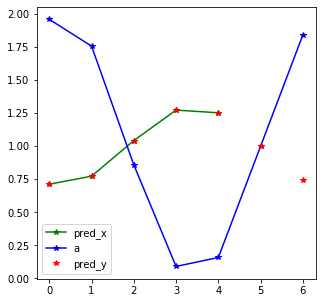

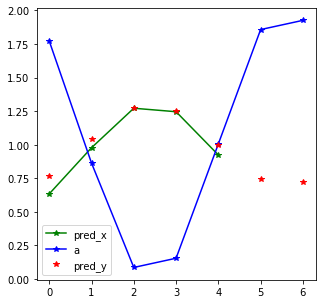

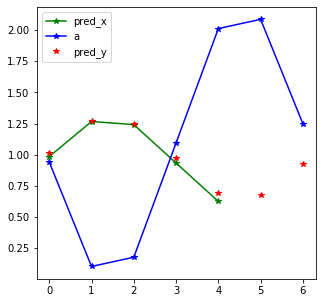

In [ ]:
# hide
# basic
from fastseq.data.load import *
horizon,lookback = 2,5
t = np.arange(-5,5.)
a = np.sin(t)
df = pd.DataFrame({'pred':[i + (i*.6)*a*-.5 for i in range(1,5)],'a':[i+a for i in range(1,5)]})
dl = DfDataLoader(df,'pred', horizon = horizon, lookback = lookback,after_batch=NormalizeTSMulti(),
                  num_workers = 1)
for o in dl:
    for a in o[:-1]:
        test_close(a[0].mean(),0)
        test_close(a[0].std(),1,.5)
    test_eq(type(o),Tuple)
    o_new = dl.after_batch[0].decode(o)
    test_eq(o_new[0].mean()!=0, True)
    test_eq(o_new[0].std()!=1, True)
    test_eq(type(o_new),Tuple)
    
test_eq(type(dl.one_batch()),Tuple)

dl.show_batch(max_n = 3)

# TSDataLoaders

## Utils

In [ ]:
def concat_ts_list(train, val):
    items=L()
    assert len(train) == len(val)
    for t, v in zip(train, val):
        items.append(np.concatenate([t,v],1))
    return items

In [ ]:
a = [np.random.randn(3,10)]*50
b = [np.random.randn(3,5)]*50
r = concat_ts_list(a,b)
test_eq(r[0].shape,(3,15))
test_eq(r[0], np.concatenate([a[0],b[0]],1))

In [ ]:
# export
def make_test_df(df:L(), horizon:int, lookback:int, keep_lookback:bool = False):
    """Splits the series in `df` based on `horizon + lookback`*, where the last part will go into `val` and the first in `train`.

    *if `keep_lookback`:
        it will only remove `horizon` from `train` otherwise also lookback.
    """
    train, val = {}, {}  
    for col in df:
        train[col], val[col] = [], []        
        if type(df.loc[0, col])==pd.Series or type(df.loc[0, col]) == np.ndarray:
            for row in df[col]:
                val[col].append(row.flatten()[-(horizon+lookback):])
                if keep_lookback:
                    train[col].append(row.flatten()[:-(horizon)])
                else:
                    train[col].append(row.flatten()[:-(horizon+lookback)])
        else:
            val[col]   = df[col]
            train[col] = df[col]

    return pd.DataFrame(train), pd.DataFrame(val)


In [ ]:
# hide
from fastseq.data.external import *
horizon,lookback = 5,10
df = dummy_data_generator_multi(70)
train, val = make_test_df(df, 5, 2)
test_eq(train.loc[0,'x'].shape, (63,))
train.head()

,x,weather,city,cont
0,"[1.612921605733978, 1.47891044491827, 1.413363823762296, 1.271907098351843, 1.0387136040877472, 1.114216086329402, 1.0557293593135424, 0.987672105411565, 1.0489996459738842, 1.071883423205351, 1.1219296493982212, 1.1399974868595888, 1.123289864699274, 1.106510740750381, 1.233227633990052, 1.034522714104727, 1.1176695833272257, 0.975851167090293, 1.0355809276770724, 1.0298934642663469, 0.9436018360870987, 1.0219702982949297, 0.8345272986228337, 0.8716638247304984, 0.8474963665964692, 0.7908449772324349, 0.871804058483813, 0.770087527269653, 0.8886193837737166, 0.654040519743553, 0.551732767...","[3.657479328768722, 3.5816329179150417, 3.555542491400689, 3.6154411988655477, 3.7855917687734886, 4.074261095048275, 4.471897830208556, 4.95181095513964, 5.473296470740827, 5.9868089660961346, 6.4404774154528885, 6.78706583674848, 6.990410443759119, 7.03043660276652, 6.906060211136078, 6.635577925220545, 6.254503201965017, 5.811157755478143, 5.360629933262691, 4.957921504163446, 4.651196600586685, 4.476013360103939, 4.45127019937874, 4.577359395308763, 4.836725498488537, 5.196714372314088, 5.614309047530202, 6.042114987600157, 6.434805794415467, 6.755187118495171, 6.979087125037338, 7.098...",0,-0.976056
1,"[-3.1140546538693363, -2.8481077610099192, -2.4354787492853873, -2.2150170831828118, -2.0909070712862494, -1.5410558131055814, -1.4017859795344314, -0.8935822760901894, -0.6590124035904346, -0.5282720804841972, -0.3385120820727821, -0.21673432640631593, -0.17416264268114848, 0.052416834291830625, 0.12157613717827977, 0.19061388720691502, 0.10991480397760327, 0.08466580994270469, 0.16668275330319185, 0.07639636776163893, 0.11356456427474498, 0.12963669093473765, 0.16977368782408067, -0.03782958962029162, 0.038460517087878496, 0.1548529152118413, 0.002534787196585848, 0.20639115972342947, 0....","[2.8985849356649194, 3.0054178400953715, 3.1795888278925086, 3.407127028682453, 3.66685403425879, 3.933244159964308, 4.179871829846747, 4.382980497120286, 4.524691097448611, 4.595416715654727, 4.595157351738636, 4.533499920877329, 4.4283234874071224, 4.303384598113805, 4.18510882894973, 4.099021864572005, 4.066302113187103, 4.100920445168885, 4.207753349599329, 4.381924337396438, 4.609462538186411, 4.869189543762747, 5.135579669468251, 5.382207339350682, 5.5853160066242475, 5.727026606952577, 5.797752225158696, 5.797492861242617, 5.735835430381296, 5.630658996911082, 5.50572010761781, 5.38...",0,-1.436185
2,"[2.1118532562732355, 1.8068663468499804, 1.527934562153409, 1.406067285751141, 1.1585619489527559, 1.1402941080126048, 1.0099967552493194, 0.8646678801238339, 0.8142304897473087, 0.9112906278861205, 1.0442805642264203, 0.9591827955307027, 0.957894685929353, 1.044117653494989, 0.9811992540548858, 1.0206868529322806, 1.0410349440155704, 1.0437962337950646, 1.1061989289696814, 0.8426307437969489, 0.831702897180468, 0.7201130518910407, 0.650900916931498, 0.5465428100207749, 0.36949487737369935, 0.38285485665061464, 0.1576078420891907, 0.06413040147056799, -0.03070265687786438, 0.12102205772380...","[2.5101463833657043, 2.4616433746833843, 2.362869959084365, 2.2403272359682784, 2.129171447318673, 2.0625469961572156, 2.0614744916427403, 2.1283292487399743, 2.245871503703059, 2.382127653004465, 2.4996699079675384, 2.566524665064772, 2.5654521605502962, 2.4988277093888382, 2.387671920739227, 2.2651291976231316, 2.1663557820241337, 2.117852773341811, 2.1294441923763086, 2.1913060183274853, 2.2769371517957735, 2.351181350797564, 2.3808942123112087, 2.3450551271778766, 2.2412887804328223, 2.0868349358219147, 1.9136671968727181, 1.7592133522618183, 1.6554470055167507, 1.6196079203834062, 1.6...",0,0.641323
3,"[1.3752956972998553, 1.179040892777373, 0.9514729236958961, 0.8710357959660242, 0.8714059214945259, 0.9703902466701076, 1.1330334731898146, 1.1079408011663656, 1.1561707329127893, 1.1897290746772033, 1.303198186723392, 1.2257084454490788, 1.1500825918013138, 1.1606204753087899, 1.0913336941920182, 1.1439480743856303, 1.20

In [ ]:
a = pd.DataFrame({'a':[np.arange(0,15)]*50,'b':[np.arange(0,15)]*50, 'c':[3]*50})
train, val = make_test_df(a,5,2)
test_eq(train['a'][0].max(),7)
test_eq(val['a'][0].min(),8)
test_eq(val['c'][0],val['c'][1])
train.head(), val.head()

(                          a                         b  c
 0  [0, 1, 2, 3, 4, 5, 6, 7]  [0, 1, 2, 3, 4, 5, 6, 7]  3
 1  [0, 1, 2, 3, 4, 5, 6, 7]  [0, 1, 2, 3, 4, 5, 6, 7]  3
 2  [0, 1, 2, 3, 4, 5, 6, 7]  [0, 1, 2, 3, 4, 5, 6, 7]  3
 3  [0, 1, 2, 3, 4, 5, 6, 7]  [0, 1, 2, 3, 4, 5, 6, 7]  3
 4  [0, 1, 2, 3, 4, 5, 6, 7]  [0, 1, 2, 3, 4, 5, 6, 7]  3,
                             a                           b  c
 0  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3
 1  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3
 2  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3
 3  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3
 4  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3)

In [ ]:
# hide
train, val = make_test_df(a,5,2,True)
test_eq(train['a'][0].max(),9)
test_eq(val['a'][0].min(),8)
test_eq(val['c'][0],val['c'][1])
train.head(), val.head()

(                                a                               b  c
 0  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  3
 1  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  3
 2  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  3
 3  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  3
 4  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  3,
                             a                           b  c
 0  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3
 1  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3
 2  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3
 3  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3
 4  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3)

## Dataloaders

In [ ]:
#export
class DfDataLoaders(DataLoaders):
    @classmethod
    @delegates(DfDataLoader.__init__)
    def from_df(cls, dataset:pd.DataFrame, y_name:str, horizon:int, valid_pct=1.5, seed=None, lookback=None, step=1,
                   incl_test = True, path:Path='.', device=None, norm=True, **kwargs):
        """Create an list of time series.
        The `DataLoader` for the test set will be save as an attribute under `test`
        """
        lookback = ifnone(lookback, horizon * 4)
        device = ifnone(device, default_device())
        if incl_test:
            dataset, test = make_test_df(dataset, horizon, lookback, keep_lookback = True)
        train, valid = make_test_df(dataset, horizon + int(valid_pct*horizon), lookback , keep_lookback = True)
        if norm and 'after_batch' not in kwargs:
            make_ones = kwargs.pop('make_ones', True)
            kwargs.update({'after_batch':L(NormalizeTSMulti(make_ones=make_ones))})
        db = DataLoaders(*[DfDataLoader(ds, y_name, horizon=horizon, lookback=lookback, step=step, device=device, norm = False, **kwargs)
                           for ds in [train,valid]], path=path, device=device)
        if incl_test:
            db.test = DfDataLoader(test, y_name, horizon=horizon, lookback=lookback, step=step, name='test', device=device, **kwargs)

            print(f"Train:{db.train.n}; Valid: {db.valid.n}; Test {db.test.n}")
        else:
            print(f"Train:{db.train.n}; Valid: {db.valid.n}")

        return db

In [ ]:
# hide
# device `cpu`
horizon,lookback = 2,5
t = np.arange(-5,25)
a = np.sin(t)
df = pd.DataFrame({'pred':[i + (i*.6)*a*-.5 for i in range(1,100)],'a':[i+a for i in range(1,100)]})


In [ ]:
# hide
data = DfDataLoaders.from_df(df, 'pred', horizon = horizon, lookback=lookback, step=5, device = torch.device('cpu'))
test_eq(data.valid.dataset.iloc[0,0].shape[-1],data.valid.dataset.iloc[0,1].shape[-1])
test_eq(data.valid.dataset.iloc[0,0].shape[-1]>lookback+horizon, True)
test_eq(hasattr(data,'test'),True)
test_eq([o[0].device for o in data.train][0], torch.device('cpu'))
test_eq([o[0].device for o in data.test][0], torch.device('cpu'))

Train:396; Valid: 99; Test 99


In [ ]:
# hide
# default device

data = DfDataLoaders.from_df(df,'pred', horizon = horizon, lookback=lookback, step=5)
test_eq(data.valid.dataset.iloc[0,0].shape[-1]>lookback+horizon, True)
test_eq(hasattr(data,'test'),True)
test_eq([o[0].device for o in data.train][0], default_device())
test_eq([o[0].device for o in data.test][0], default_device())

Train:396; Valid: 99; Test 99


In [ ]:
# hide
dbunch = DfDataLoaders.from_df(df,'pred',horizon=horizon, lookback = lookback, incl_test=False)
test_eq(hasattr(dbunch,'test'),False)

Train:1881; Valid: 396


In [ ]:
show_doc(DfDataLoaders.from_df, name='DfDataLoaders.from_df')

<h4 id="DfDataLoaders.from_df" class="doc_header"><code>DfDataLoaders.from_df</code><a href="__main__.py#L3" class="source_link" style="float:right">[source]</a></h4>

> <code>DfDataLoaders.from_df</code>(**`dataset`**:`DataFrame`, **`y_name`**:`str`, **`horizon`**:`int`, **`valid_pct`**=*`1.5`*, **`seed`**=*`None`*, **`lookback`**=*`None`*, **`step`**=*`1`*, **`incl_test`**=*`True`*, **`path`**:`Path`=*`'.'`*, **`device`**=*`None`*, **`norm`**=*`True`*, **`min_seq_len`**=*`None`*, **`max_std`**=*`2`*, **`bs`**=*`64`*, **`shuffle`**=*`False`*, **`num_workers`**=*`None`*, **`verbose`**=*`False`*, **`do_setup`**=*`True`*, **`pin_memory`**=*`False`*, **`timeout`**=*`0`*, **`batch_size`**=*`None`*, **`drop_last`**=*`False`*, **`indexed`**=*`None`*, **`n`**=*`None`*, **`wif`**=*`None`*, **`before_iter`**=*`None`*, **`after_item`**=*`None`*, **`before_batch`**=*`None`*, **`after_batch`**=*`None`*, **`after_iter`**=*`None`*, **`create_batches`**=*`None`*, **`create_item`**=*`None`*, **`create_batch`**=*`None`*, **`retain`**=*`None`*, **`get_idxs`**=*`None`*, **`sample`**=*`None`*, **`shuffle_fn`**=*`None`*, **`do_batch`**=*`None`*)

Create an list of time series.
The `DataLoader` for the test set will be save as an attribute under `test`

In [ ]:
from fastseq.data.external import *
horizon,lookback = 5,10
df = dummy_data_generator_multi(70)
df['city'] = df['city'].astype(float)
df.head()

,x,weather,city,cont
0,"[[-2.3198711204893443, -2.209596574356538, -2.060060731549629, -1.9006233389732092, -1.816196046496894, -1.6820719652727505, -1.5346462796784903, -1.4360797256785838, -1.3326199005914652, -1.2127505757712658, -1.0028804438867107, -0.8985676374901165, -0.7641192083841175, -0.628488786694089, -0.47628998425739993, -0.3633161658044124, -0.23602049503418498, -0.17696757149926573, -0.13689945594987554, -0.11870073226935465, -0.06599735761168267, -0.01850120346914021, -0.06586364928066067, -0.06352085673006191, -0.06619371157044221, -0.09160237384623222, -0.10059366992924493, -0.0888382613686913...","[[1.339404895368971, 1.4444107366537084, 1.4432836518659906, 1.358297628821003, 1.2232083059978718, 1.0786803222607348, 0.9667767228870401, 0.9252552918674434, 0.9824428995248226, 1.1533810072722641, 1.4377638810104596, 1.8199490025357727, 2.2710393244109603, 2.7527571819049994, 3.22258764928892, 3.6394975957832174, 3.9694588280792225, 4.1900300221462, 4.293379097768891, 4.287338135162586, 4.194348458357921, 4.048438260663614, 3.8906406728593086, 3.763470620673794, 3.7052057688380953, 3.7447431647895497, 3.897725326731762, 4.164457988764019, 4.5298996894732975, 4.965723558536664, 5.4341718...",0.0,-1.115652
1,"[[2.7591792108975315, 2.668117394431592, 2.159751721673129, 2.2477919817460426, 2.0077519361281535, 1.7335049737157582, 1.6310696373796658, 1.6210356224917593, 1.3837836038182878, 0.9833616612461666, 0.8723216611657005, 0.7936386129253366, 0.5724165496278959, 0.5988868657126396, 0.4528249045278938, 0.15063634016796587, -0.16770003427200625, -0.2716185910922122, -0.29616942950107333, -0.5646283406001343, -0.5643375977029499, -0.8675397509382181, -0.8759431816187975, -0.7212380065205595, -0.46187865965192065, -0.6156026840802095, -0.29313735681533454, -0.0015277782965351973, 0.05025638532248...","[[1.5042375001966732, 1.398649680838704, 1.4931876174715548, 1.750085930640204, 2.09526919830572, 2.443914196244725, 2.726688391016645, 2.9085506364703555, 2.9946251725372703, 3.021914308224102, 3.0401717780466146, 3.0887093198648357, 3.177191386487114, 3.277193217158741, 3.327849523285882, 3.2543668430741675, 2.993920482965784, 2.520833627974626, 1.862782288543858, 1.1021805705778591, 0.3611911355776285, -0.2262897283823202, -0.5482734864913688, -0.5445866758926283, -0.22443461895510652, 0.33370030868510936, 1.0002534178500069, 1.626205411734611, 2.079682172307705, 2.2776611110561538, 2.2...",0.0,-0.371091
2,"[[2.162104413832849, 1.6171147868999243, 1.3024553074651823, 1.0930323167494356, 1.0265383809096156, 0.9731008844301962, 0.8457186373277815, 0.7346250557660533, 0.8939900167524795, 0.9234313006717518, 1.1671242787197176, 1.3103113700708415, 1.4291163183180406, 1.3269123312457674, 1.65671005980489, 1.3969278548371222, 1.5730589359750276, 1.3786925561491064, 1.2697984429285274, 1.16690048972539, 1.0722439676467848, 0.9095639936784881, 0.5264946017429173, 0.33673424154063253, -0.0026100684576313153, -0.33040686691915916, -0.5197326674437451, -0.7202829489444988, -1.0259873043352843, -1.284062...","[[9.435254087590007, 9.271577879209035, 8.960906527171735, 8.57229384617224, 8.197715946954702, 7.9246875020073775, 7.8102492278515285, 7.86409150776893, 8.045841233516121, 8.27729900868538, 8.465941580530915, 8.532638635584888, 8.435280956990859, 8.181252098953122, 7.825026778500456, 7.4516410506637545, 7.151014541787171, 6.990844454835453, 6.996214219242613, 7.142040405574644, 7.360625810866835, 7.56205080877496, 7.6612793442681575, 7.603836700317666, 7.382339322719156, 7.038896428329043, 6.652638330615305, 6.316088282323575, 6.107445679861608, 6.067083631472916, 6.1853117538756885, 6.40...",0.0,0.859301
3,"[[-0.7028225385354163, -0.8443901019455907, -0.8142633562028392, -0.7274985348215032, -0.608298082265215, -0.7767181609498461, -0.3485452194522807, -0.657396845154389, -0.6911182285390989, -0.6606551001545307, -1.0744502171378438, -1.2213127874041645, -1.179821320558343, -1.2067845331407514, -1.4486990526929608, -1.

Train:120; Valid: 110; Test 10


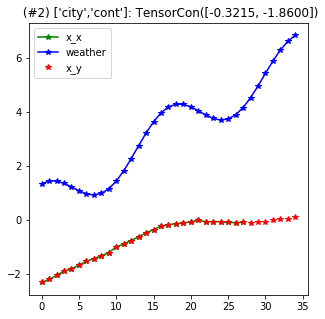

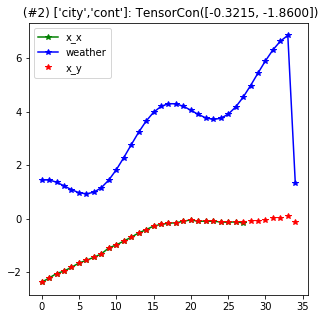

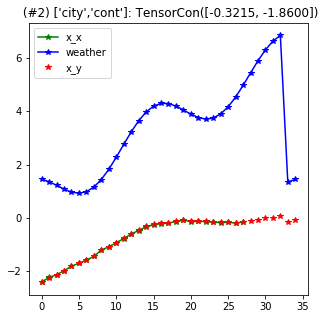

In [ ]:
dbunch =  DfDataLoaders.from_df(df, 'x', horizon = 7, lookback=28, step=1, bs=32)
dbunch.train.show_batch(max_n=3)

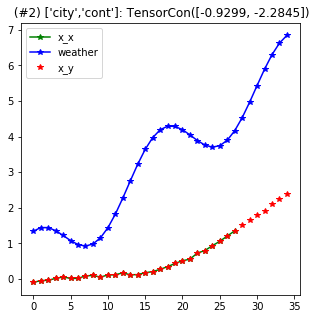

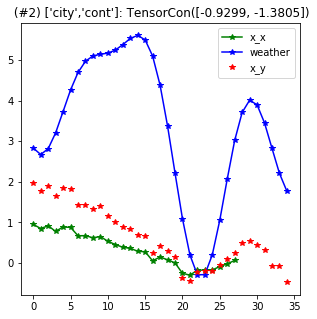

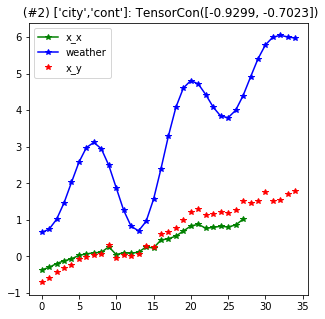

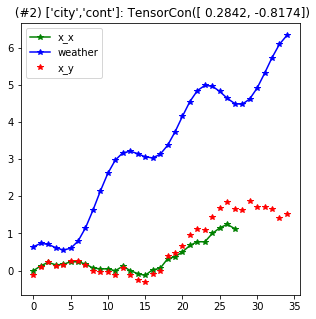

In [ ]:
dbunch.test.show_batch(max_n=4)

In [ ]:
# hide
from nbdev.export import *

notebook2script()

Converted 00_core.ipynb.
Converted 01_data.external.ipynb.
Converted 020_data.load_pd.ipynb.
Converted 02_data.load.ipynb.
Converted 03_data.core.ipynb.
Converted 03_data.core_pd.ipynb.
Converted 050_nbeats.models_multi.ipynb.
